<a href="https://colab.research.google.com/github/grantrzchan/HTX_Armed_Robberies/blob/master/HTX_Armed_Robberies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
'''monthly robberies data set'''
import pandas as pd
import numpy as np
import math
from sklearn.metrics import mean_squared_error as mse
from math import sqrt
from matplotlib import pyplot as plt

#load data set
data_series = pd.read_csv('./data/HTX_robberies.csv', header=0, index_col=0, parse_dates=True, squeeze=True)

In [2]:
#split data set into model development data set and cross validation set, use last year of data as cv
data_end = len(data_series) - 12
data_set, cv_set = data_series[0:data_end], data_series[data_end::]
print(f'Data set: {len(data_set)} months, Validation set: {len(cv_set)} months')

#save training and cv sets to csv format
data_set.to_csv('data_set.csv', header = False)
cv_set.to_csv('cv_set.csv', header = False)

Data set: 102 months, Validation set: 12 months


In [3]:
#create training set and test set
X = data_set.values
X = X.astype('float32')

#start with train set of 50%
train_size = int(0.5*len(X))
train_set, test_set = X[0:train_size], X[train_size::]

In [4]:
#use walk forward validation to create baseline prediction forecast using the persistence model
#create foreacst history
historic_obs = [x for x in train_set]
#create baseline predictions
predictions = []
for i in range(len(test_set)):
    #make prediction at t using observation at t-1
    y_hat = historic_obs[-1]
    predictions.append(y_hat)
    #actual t observation from test set
    observation = test_set[i]
    #update historic observations with actual t observation
    historic_obs.append(observation)
    print(f'Predicted: {y_hat: .3f}, Expected: {observation: .3f}')
#report the performance of the forecast using RMSE
rmse = sqrt(mse(test_set, predictions))
print(f'RMSE: {rmse: .3f}')

Predicted:  816.000, Expected:  841.000
Predicted:  841.000, Expected:  836.000
Predicted:  836.000, Expected:  930.000
Predicted:  930.000, Expected:  1024.000
Predicted:  1024.000, Expected:  699.000
Predicted:  699.000, Expected:  669.000
Predicted:  669.000, Expected:  679.000
Predicted:  679.000, Expected:  817.000
Predicted:  817.000, Expected:  642.000
Predicted:  642.000, Expected:  885.000
Predicted:  885.000, Expected:  877.000
Predicted:  877.000, Expected:  912.000
Predicted:  912.000, Expected:  929.000
Predicted:  929.000, Expected:  894.000
Predicted:  894.000, Expected:  971.000
Predicted:  971.000, Expected:  838.000
Predicted:  838.000, Expected:  604.000
Predicted:  604.000, Expected:  748.000
Predicted:  748.000, Expected:  849.000
Predicted:  849.000, Expected:  889.000
Predicted:  889.000, Expected:  846.000
Predicted:  846.000, Expected:  964.000
Predicted:  964.000, Expected:  905.000
Predicted:  905.000, Expected:  818.000
Predicted:  818.000, Expected:  846.00

In [5]:
# show summary statistics of data_set time series
print(data_set.describe())

count     102.000000
mean      811.862745
std       116.109460
min       464.000000
25%       740.500000
50%       820.000000
75%       879.250000
max      1087.000000
Name: 982.0, dtype: float64


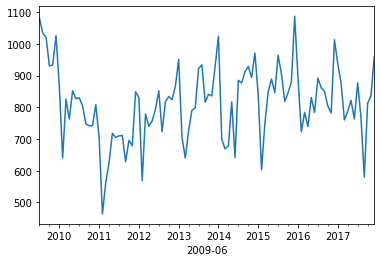

In [6]:
#plot the data
data_set.plot()
plt.show()

### Line plot observations
- There is a trend of increasing robberies
- There is high variability among data points, which corresponds to the wide spread between the quartile ranges observed above
- The variance between data points seem to increase over time, as observed from the widening ampitude of the fluctuations in the data
- The data set is non-stationary

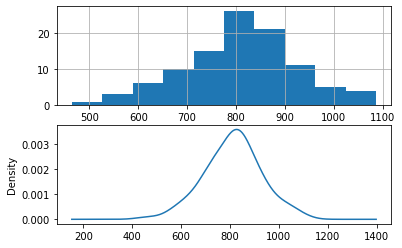

In [7]:
#plot histogram and denisty plot
plt.figure(1)
plt.subplot(211)
data_set.hist()
plt.subplot(212)
data_set.plot(kind='kde')
plt.show()

### Histogram and Density plot observations
- The data distribution is largely gaussian
- The data seem to be quadratic or exponential, due to the left shift and the short right tail


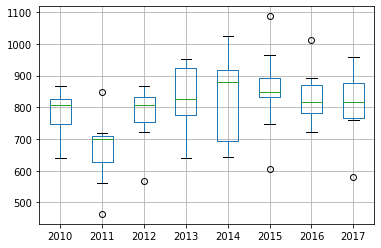

In [9]:
#group data by year for box plot analysis
#1974 only has 10 months and not a full year, so we exclude it
grps = data_set['2010':'2018'].groupby(pd.Grouper(freq='A'))
yrs = pd.DataFrame({name.year: grp.values for name, grp in grps})
yrs.boxplot()
plt.show()

### Box plot observations
- The earlier 2 years seem to have a much smaller variance, with the 1st and 3rd quantile being much closer to the median values.
- The variance changes over time, but does not appear to do so consistently.
- The median values do not exhibit a linear trend.

In [10]:
#Implement an ARIMA model to forecast the number of robberies over time
#first check for stationarity of the data set using the augmented Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller

def check_stationary(data):
    '''function to check data stationarity using adfuller from statsmodel'''
    result = adfuller(data)
    print(f'ADF Statistic: {result[0]: .3f}')
    print(f'p-value: {result[1]: .3f}')
    print(f'Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))


#check if stationary using Dickey-Fuller
check_stationary(data_set.values)

ADF Statistic: -1.755
p-value:  0.403
Critical Values:
	1%: -3.507
	5%: -2.895
	10%: -2.585


### Dickey-Fuller Test observation:
- The test statistic value is 0.797 , which is larger than the critical value of -2.893. This indicates that we cannot reject the null hypothesis, which claims that the data is non-stationary, with a significance level of less than 5%.

In [10]:
#Employ first order differencing
def differencing(data):
    '''Function executes differencing of order 1 when called'''
    differenced = [(data[i] - data[i-1]) for i in range(1, len(data))]
    return differenced

#executing differencing of order 1
stationary_X = differencing(X)

#check if the data is stationary now
check_stationary(stationary_X)

ADF Statistic: -3.981
p-value:  0.002
Critical Values:
	1%: -3.503
	5%: -2.893
	10%: -2.584


- The test statistic value is -3.981 , which is smaller than the critical value of -2.893. This indicates that we can reject the null hypothesis, which claims that the data is non-stationary, with a significance level of less than 5%.
- Differencing by order of 1 seems to have made the data set stationary.

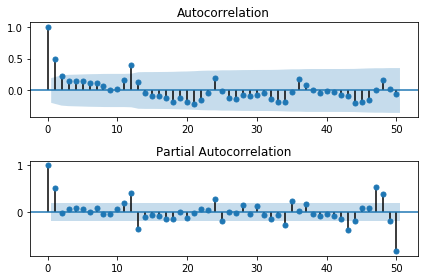

In [11]:
#create ACF and PACF plots to check for autocorrelation
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plt.figure()
plt.subplot(211)
plot_acf(X, lags=50, ax=plt.gca())
plt.subplot(212)
plot_pacf(X, lags=50, ax=plt.gca())

#fix any plot overlap with tight layout
plt.tight_layout()
plt.show()

### ACF and PACF plot observations

- The ACF plot shows that lags are significant for 10-12 months.
- The PACF plot shows that lags are significant for likely just 2 months.
- The PACF plot suggests that perhaps the autocorrelations at lag 3 and thereafter are due to the propagation of the autocorrelations at lags 1 and 2.
- The plot suggest an ARMA(2,2) that can be used for modelling.
- Since differencing order of the data is 1, an ARIMA(2,1,2) should be a good starting point for modelling the data.

In [12]:
#try an ARIMA model
from statsmodels.tsa.arima_model import ARIMA
arima1212_hist = [x for x in train_set]
arima1212_pred = []
for i in range(len(test_set)):
    # predict
    model = ARIMA(arima1212_hist, order=(2,1,2))
    model_fit = model.fit(disp=0)
    arima1212_y_hat = model_fit.forecast()[0]
    arima1212_pred.append(arima1212_y_hat)
    # observation
    obs = test_set[i]
    arima1212_hist.append(obs)
    print('>Predicted=%.3f, Expected=%.3f' % (arima1212_y_hat, obs))
# report performance
rmse = sqrt(mse(test_set, arima1212_pred))
print(f'RMSE: {rmse: .3f}')

>Predicted=812.125, Expected=841.000
>Predicted=844.912, Expected=836.000
>Predicted=826.487, Expected=930.000
>Predicted=892.651, Expected=1024.000
>Predicted=952.743, Expected=699.000
>Predicted=758.210, Expected=669.000
>Predicted=784.138, Expected=679.000
>Predicted=722.341, Expected=817.000
>Predicted=810.329, Expected=642.000
>Predicted=623.580, Expected=885.000
>Predicted=830.324, Expected=877.000
>Predicted=841.249, Expected=912.000
>Predicted=857.926, Expected=929.000
>Predicted=867.818, Expected=894.000
>Predicted=850.315, Expected=971.000
>Predicted=924.422, Expected=838.000
>Predicted=833.856, Expected=604.000
>Predicted=706.299, Expected=748.000
>Predicted=790.248, Expected=849.000
>Predicted=823.096, Expected=889.000


c:\users\grant\appdata\local\programs\python\python37-32\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
c:\users\grant\appdata\local\programs\python\python37-32\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
c:\users\grant\appdata\local\programs\python\python37-32\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
c:\users\grant\appdata\local\programs\python\python37-32\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()


>Predicted=862.015, Expected=846.000
>Predicted=836.403, Expected=964.000
>Predicted=904.495, Expected=905.000
>Predicted=869.110, Expected=818.000
>Predicted=829.389, Expected=846.000
>Predicted=851.826, Expected=880.000
>Predicted=866.145, Expected=1087.000
>Predicted=982.177, Expected=891.000
>Predicted=878.178, Expected=723.000
>Predicted=795.237, Expected=784.000
>Predicted=840.563, Expected=739.000
>Predicted=820.556, Expected=831.000
>Predicted=862.620, Expected=784.000
>Predicted=834.779, Expected=892.000
>Predicted=878.023, Expected=862.000
>Predicted=856.036, Expected=850.000
>Predicted=838.945, Expected=804.000
>Predicted=808.692, Expected=782.000
>Predicted=790.001, Expected=1013.000
>Predicted=890.202, Expected=937.000
>Predicted=853.952, Expected=876.000
>Predicted=819.549, Expected=760.000
>Predicted=767.516, Expected=788.000
>Predicted=786.922, Expected=822.000
>Predicted=811.697, Expected=763.000
>Predicted=789.773, Expected=877.000
>Predicted=846.550, Expected=767.000

In [24]:
#Use Grid Search to find the optimal p,d,q hyperparameters
def evaluate_arima_model(data, arima_order):
    '''Function to evaluate data set X based on ARIMA order with some (p,d,q) and return RMSE'''
    #prepare training data
    data = data.astype('float32')
    train_size = int(len(data) * 0.50)
    train, test = data[0:train_size], data[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    rmse = sqrt(mse(test, predictions))
    return rmse

def evaluate_models(data, p_val, d_val, q_val):
    #convert data set to float to prevent numpy error
    data = data.astype('float32')
    best_rmse, best_config = float('inf'), None
    #loop through all values of p,d,q to try every configuration order for ARIMA
    for p in p_val:
        for d in d_val:
            for q in q_val:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(data, order)
                    if rmse < best_rmse:
                        best_rmse, best_config = rmse, order
                    print('ARIMA%s, RMSE = %.3f' % (order, rmse))
                except:
                    continue
    print('Best ARIMA%s, RMSE = %.3f' % (best_config, best_rmse))

In [25]:
#evaluate data set with all possible hyperparameter configurations
p_val = range(0,5)
d_val = range(0,2)
q_val = range(0,5)

#turn off verbose warning messages
import warnings
warnings.filterwarnings("ignore")
evaluate_models(X, p_val, d_val, q_val)

ARIMA(0, 0, 0), RMSE = 107.866
ARIMA(0, 0, 1), RMSE = 102.115
ARIMA(0, 0, 2), RMSE = 101.937
ARIMA(0, 0, 3), RMSE = 103.589
ARIMA(0, 0, 4), RMSE = 105.831
ARIMA(0, 1, 0), RMSE = 120.555
ARIMA(0, 1, 1), RMSE = 113.698
ARIMA(0, 1, 2), RMSE = 107.761
ARIMA(0, 1, 3), RMSE = 108.365
ARIMA(0, 1, 4), RMSE = 108.934
ARIMA(1, 0, 0), RMSE = 103.374
ARIMA(1, 0, 1), RMSE = 105.289
ARIMA(1, 0, 2), RMSE = 104.850
ARIMA(1, 1, 0), RMSE = 118.463
ARIMA(1, 1, 1), RMSE = 107.399
ARIMA(2, 0, 0), RMSE = 104.202
ARIMA(2, 0, 1), RMSE = 104.353
ARIMA(2, 0, 2), RMSE = 105.139
ARIMA(2, 1, 0), RMSE = 116.470
ARIMA(2, 1, 1), RMSE = 108.076
ARIMA(2, 1, 2), RMSE = 109.027
ARIMA(3, 0, 0), RMSE = 105.737
ARIMA(3, 0, 1), RMSE = 105.118
ARIMA(3, 1, 0), RMSE = 113.372
ARIMA(3, 1, 1), RMSE = 109.632
ARIMA(3, 1, 2), RMSE = 108.518
ARIMA(4, 0, 0), RMSE = 105.823
ARIMA(4, 0, 1), RMSE = 107.738
ARIMA(4, 1, 0), RMSE = 112.093
ARIMA(4, 1, 1), RMSE = 111.094
ARIMA(4, 1, 2), RMSE = 109.340
Best ARIMA(0, 0, 2), RMSE = 101.937


### Grid Search Results
- The best ARIMA model is an ARIMA(0,1,2) with an RMSE of 49.821

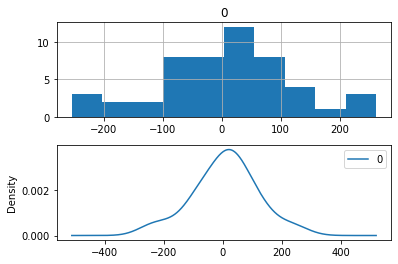

In [13]:
#Check residual errors for other features
#plot residual
residuals = [test_set[i]-arima1212_pred[i] for i in range(len(test_set))]
residuals = pd.DataFrame(residuals)
plt.figure()
plt.subplot(211)
residuals.hist(ax=plt.gca())
plt.subplot(212)
residuals.plot(kind='kde', ax=plt.gca())
plt.show()

### Histogram and density plot observations
- Both histogram and density plots show a distribution that is much closer to Gaussian, however, the longer right tail suggests that some other relationship has not been captured.

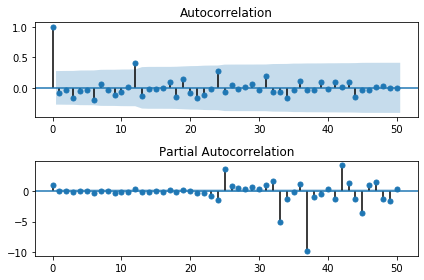

In [14]:
#check ACF and PACF
plt.figure()
plt.subplot(211)
plot_acf(residuals, lags=50, ax=plt.gca())
plt.subplot(212)
plot_pacf(residuals, lags=50, ax=plt.gca())
plt.tight_layout()
plt.show()

### ACF and PACF observations
- Any correlation and partial correlation seems to have been captured.
- There is an anomaly at t-38 in the PACF plot.

In [15]:
#use Box-Cox transform to further evaluate starting data set for any potential relationships
from scipy.stats import boxcox
from statsmodels.graphics.gofplots import qqplot
#turn off verbose warning messages
import warnings
warnings.filterwarnings("ignore")
transformed, lamd = boxcox(X)
print(f'Lambda: {lamd: .3f}')

Lambda:  1.332


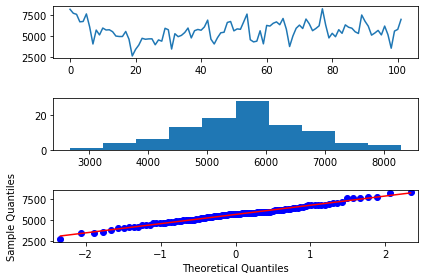

In [16]:
#plot transformed data, histogram and q-q plots
plt.figure()
#plot transformed data
plt.subplot(311)
plt.plot(transformed)
#plot histogram
plt.subplot(312)
plt.hist(transformed)
#plot q-q plot
plt.subplot(313)
qqplot(transformed, line='r', ax=plt.gca())
plt.tight_layout()
plt.show()

### Data transform results
- Transforming the data has reduced the high variability of the data in the later years.
- The transformed data has a more uniform and well-behaved distribution
- The transformed data is still not perfectly Gaussian.

In [32]:
#create a function for inverse Box-Cox transform to revert transformed data back to original units
from math import log
from math import exp
def boxcox_inverse(value, lamb):
    if lamb == 0:
        return exp(value)
    return exp(log(lamb*value + 1)/lamb)

In [33]:
#reevaluate ARIMA(0,1,2) with the box-cox transformed time series
hist_t = [x for x in train_set]
pred_t = []
#predict using transformed data
for i in range(len(test_set)):
    #transform
    tf, lam = boxcox(hist_t)
    #don't do transform if lambda is less than 5
    if lam < -5:
        tf, lam = hist_t, 1
    model = ARIMA(tf, order=(0,0,2))
    model_fit = model.fit(disp=0)
    y_hat_t = model_fit.forecast()[0]
    #invert transformed prediction
    y_hat_t = boxcox_inverse(y_hat_t, lam)
    pred_t.append(y_hat_t)
    #observation
    obs_t = test_set[i]
    hist_t.append(obs_t)
    print('>Predicted=%.3f, Expected=%.3f' % (y_hat_t, obs_t))
# report performance
rmse = sqrt(mse(test_set, pred_t))
print(f'RMSE: {rmse: .3f}')
##finalize model and save 
# monkey patch around bug in ARIMA class
# def __getnewargs__(self):
#     return ((self.endog),(self.k_lags, self.k_diff, self.k_ma))
# ARIMA.__getnewargs__ = __getnewargs__
model_fit.save('model_arima012.pkl')
np.save('model_lambda.npy',[lam])

>Predicted=777.812, Expected=841.000
>Predicted=823.577, Expected=836.000
>Predicted=813.407, Expected=930.000
>Predicted=872.105, Expected=1024.000
>Predicted=924.123, Expected=699.000
>Predicted=691.407, Expected=669.000
>Predicted=745.133, Expected=679.000
>Predicted=750.474, Expected=817.000
>Predicted=820.958, Expected=642.000
>Predicted=697.409, Expected=885.000
>Predicted=851.094, Expected=877.000
>Predicted=842.218, Expected=912.000
>Predicted=837.030, Expected=929.000
>Predicted=863.477, Expected=894.000
>Predicted=837.073, Expected=971.000
>Predicted=885.536, Expected=838.000
>Predicted=808.753, Expected=604.000
>Predicted=675.743, Expected=748.000
>Predicted=798.616, Expected=849.000
>Predicted=841.283, Expected=889.000
>Predicted=839.093, Expected=846.000
>Predicted=816.913, Expected=964.000
>Predicted=893.105, Expected=905.000
>Predicted=845.668, Expected=818.000
>Predicted=794.680, Expected=846.000
>Predicted=833.317, Expected=880.000
>Predicted=848.175, Expected=1087.000

- Running the ARIMA(0,1,2) model on the transformed data set gave a slightly lower RMSE.

In [34]:
# finalize model and save to file with workaround
# transform data, use entire data set X now to train the model
import numpy
from statsmodels.tsa.arima_model import ARIMAResults
transformed, lam = boxcox(X)
# fit model
model = ARIMA(transformed, order=(0,0,2))
model_fit = model.fit(disp=0)
# save model
model_fit.save('model_arima012.pkl')
numpy.save('model_lambda.npy', [lam])

In [35]:
# # load the finalized model and make a prediction
model_fit = ARIMAResults.load('model_arima012.pkl')
lam = np.load('model_lambda.npy')
yhat = model_fit.forecast()[0]
yhat = boxcox_inverse(yhat, lam)
print(f'Predicted:{yhat: .3f}')
print(f'Actual value in CV set:{cv_set[0]: .3f}')
print(f'RMSE is {sqrt((cv_set[0]-yhat)**2): .3f}')

Predicted: 882.915
Actual value in CV set: 908.000
RMSE is  25.085


- Predicted value was very close to actual value in cross validation set, with an RMSE of 0.039

>Predicted=882.915, Expected=908.000
>Predicted=855.434, Expected=665.000
>Predicted=720.372, Expected=721.000
>Predicted=783.874, Expected=645.000
>Predicted=743.937, Expected=710.000
>Predicted=769.737, Expected=766.000
>Predicted=802.837, Expected=761.000
>Predicted=787.514, Expected=729.000
>Predicted=770.735, Expected=659.000
>Predicted=737.740, Expected=672.000
>Predicted=749.923, Expected=776.000
>Predicted=806.995, Expected=813.000
RMSE:  81.672


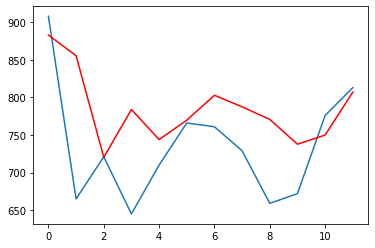

In [36]:
#use cross validation set to test how well the model can make predictions on out-of-sample data
#load CV set as target outputs
y = cv_set.values.astype('float32')
#load model and boxcox lambda
model_fit = ARIMAResults.load('model_arima012.pkl')
lamb = np.load('model_lambda.npy')
#create expanding window forecast, with all subsequent target outputs added to history
hist = [x for x in X]
pred = []
#make predictions
for i in range(len(y)):
    tf, lam = boxcox(hist)
    if lam < -5:
        tf, lam = hist, 1
    model = ARIMA(tf, order=(0,0,2))
    model_fit = model.fit(disp=False)
    yhat = model_fit.forecast()[0]
    #inverse transformed prediction
    yhat = boxcox_inverse(yhat, lam)
    pred.append(yhat)
    obs = y[i]
    hist.append(obs)
    print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
#report performance
rmse = sqrt(mse(y, pred))
print(f'RMSE: {rmse: .3f}')
#plot predictions with actuals
plt.plot(y)
plt.plot(pred, color='r')
plt.show()

>Predicted=881.118, Expected=908.000
>Predicted=844.299, Expected=665.000
>Predicted=741.697, Expected=721.000
>Predicted=798.165, Expected=645.000
>Predicted=733.930, Expected=710.000
>Predicted=779.094, Expected=766.000
>Predicted=789.318, Expected=761.000
>Predicted=786.049, Expected=729.000
>Predicted=763.091, Expected=659.000
>Predicted=727.756, Expected=672.000
>Predicted=732.429, Expected=776.000
>Predicted=776.026, Expected=813.000
RMSE:  81.019


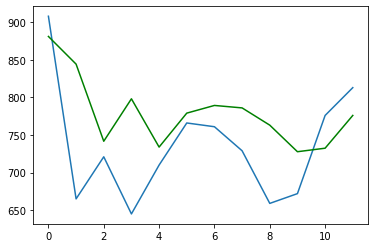

In [37]:
#try rolling window forecast, with all subsequent target outputs added to history
hist = [x for x in X]
pred = []
#make predictions
for i in range(len(y)):
    tf, lam = boxcox(hist[i:])
    if lam < -5:
        tf, lam = hist[i:], 1
    model = ARIMA(tf, order=(0,1,2))
    model_fit = model.fit(disp=False)
    yhat = model_fit.forecast()[0]
    #inverse transformed prediction
    yhat = boxcox_inverse(yhat, lam)
    pred.append(yhat)
    obs = y[i]
    hist.append(obs)
    print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
#report performance
rmse = sqrt(mse(y, pred))
print(f'RMSE: {rmse: .3f}')
#plot predictions with actuals
plt.plot(y)
plt.plot(pred, color='g')
plt.show()

### ARIMA prediction results:
- Differences between expanding window and rolling window forecasts are minimal, with an RMSE of around 53.
- ARIMA may not be sufficient to effectively model the time series
- Try more sophisticated methods, such as an LSTM RNN model